# PyGrain Tutorial

## Setup

This guide assume you have familiarity of using Cloud TPU (if not, please read https://cloud.google.com/tpu/docs/quick-starts first). This notebook can be run on a single-host TPU VM (v2-8, v3-8, v4-8).

### Create a VM
PyGrain requires python>=3.10. If you are using Cloud TPU, the VM image `tpu-ubuntu2204-base` comes with python3.10
```
export TPU_NAME=<your_tpu>
export ZONE=<your_zone>
export PROJECT=<your-project>
export ACCELERATOR=v4-8
export VERSION=tpu-ubuntu2204-base

gcloud compute tpus tpu-vm create $TPU_NAME \
--zone=$ZONE --version=$VERSION \
--project=$PROJECT \
--accelerator-type=$ACCELERATOR
```
### Install dependencies on the TPU VM
##### Install grain, jax and tfds-nightly
```
pip install grain-nightly jax[tpu] tfds-nightly -f https://storage.googleapis.com/jax-releases/libtpu_releases.html
```

##### Install opencv for the cv example used in this notebook
```
sudo apt-get update
sudo apt install libgl1-mesa-glx
pip install opencv-python matplotlib
```
##### Install orbax for checkpoint example
```
pip install orbax-checkpoint
```
##### Install jupyter notebook and dependencies
```
pip install notebook markupsafe==2.0.1
export PATH=/home/$USER/.local/bin:$PATH
```
### Start notebook
We SSH from a local machine with browser using port forwarding, this port will be used by jupyter notebook
```
gcloud compute tpus tpu-vm ssh $TPU_NAME --zone=$ZONE --ssh-flag="-4 -L 8080:localhost:8080"
```
On the VM
```
jupyter notebook --no-browser --port=8080
```
On the local machine, open http://localhost:8080

### Load PyGrain

In [2]:
import os
import cv2
import grain.python as pygrain
import matplotlib.pyplot as plt
import numpy as np
import re
import tensorflow_datasets as tfds

/home/aireenmei/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Concepts
The main class the users interact with is the `DataLoader`. It's responsible for reading and transforming input data records. Users need to iterate through the `DataLoader` to get the output elements.

The `DataLoader` uses a **Sampler** to determine which records to read next, a **DataSource** to read the records, and applies **Operations** to the read records to produce output elements. We present these concepts in the following sections.

### Samplers
A `Sampler` is responsible for determining which records to read next. This involves applying global transformations such as shuffling records, repeating for multiple epochs and sharding across multiple machines. The sampler is an `Iterator` which produces metadata objects containing the following information:
* `index`: a monotonically increasing number, unique for each record. It keeps track of the pipeline process and will be used for checkpointing.
* `record_key`: a reference to the record in the serialized file format.
* `rng`: a per-record Random Number Generator to apply random transformations.

PyGrain provides an `IndexSampler` implementation, which we explore below.

In [2]:
# Setting `num_records` to 5 to limit results.
# For full dataset, set to `len(data_source)`.
index_sampler_example = pygrain.IndexSampler(
    num_records=5,
    num_epochs=2,
    shard_options=pygrain.ShardOptions(
        shard_index=0, shard_count=1, drop_remainder=True),
    shuffle=True,
    seed=0)

# Iterator is consumed.
for record_metadata in index_sampler_example:
    print(record_metadata)

# Create new iterator.
index_sampler = pygrain.IndexSampler(
    num_records=5,
    num_epochs=2,
    shard_options=pygrain.ShardOptions(
        shard_index=0, shard_count=1, drop_remainder=True),
    shuffle=True,
    seed=0)

RecordMetadata(index=0, record_key=0, rng=Generator(Philox))
RecordMetadata(index=1, record_key=4, rng=Generator(Philox))
RecordMetadata(index=2, record_key=1, rng=Generator(Philox))
RecordMetadata(index=3, record_key=2, rng=Generator(Philox))
RecordMetadata(index=4, record_key=3, rng=Generator(Philox))
RecordMetadata(index=5, record_key=1, rng=Generator(Philox))
RecordMetadata(index=6, record_key=2, rng=Generator(Philox))
RecordMetadata(index=7, record_key=3, rng=Generator(Philox))
RecordMetadata(index=8, record_key=0, rng=Generator(Philox))
RecordMetadata(index=9, record_key=4, rng=Generator(Philox))


### Data Sources
A data source is responsible for reading indvidual records from underlying files / storage system. We provide these data sources and will show examples of using both data sources:

*   `ArrayRecordDataSource`: reads records from [ArrayRecord](https://github.com/google/array_record) files.
*   `tfds.data_source`: data source for [Tfds](https://www.tensorflow.org/datasets) datasets without any TensorFlow dependency.

#### Access GCS through GCS FUSE
For dataset stored on Google Cloud Storage (GCS) bucket, the bucket can be accessed when mounted through [Cloud Storage FUSE](https://cloud.google.com/storage/docs/gcs-fuse). Reading ArrayRecord files directly from GCS is not supported as of today.
* [Install Cloud Storage FUSE](https://cloud.google.com/storage/docs/gcsfuse-install)
* [Mount a GCS bucket](https://cloud.google.com/storage/docs/gcsfuse-mount)
(Use the flag `--implicit-dirs`)
```
gcsfuse --implicit-dirs my-bucket /path/to/mount/point
```

#### tfds.data_source

In [3]:
# Will trigger downloading this dataset (125.64 MiB) to tensorflow_datasets dataset not present in data_dir
# Will need tensorflow to download and prep dataset
# The data are in array_record format, which is the default format for tfds dataset

tfds_datasource = tfds.data_source(
    "caltech101",  # smaller dataset similar to imagenet
    split="train",
    # data_dir = "tensorflow_datasets",
    # download = False,
)

print(f"Number of Records: {len(tfds_datasource)}")

indices_to_read = [20, 23]
records_read = [tfds_datasource[x] for x in indices_to_read]
print(f"Number of records read: {len(records_read)}")
print(f"First Record Read:\n{records_read[0]}")

Number of Records: 3059
Number of records read: 2
First Record Read:
{'image': array([[[157, 157, 157],
        [159, 159, 159],
        [160, 160, 160],
        ...,
        [109, 109, 109],
        [112, 112, 112],
        [107, 107, 107]],

       [[161, 161, 161],
        [162, 162, 162],
        [162, 162, 162],
        ...,
        [108, 108, 108],
        [111, 111, 111],
        [107, 107, 107]],

       [[164, 164, 164],
        [165, 165, 165],
        [164, 164, 164],
        ...,
        [108, 108, 108],
        [110, 110, 110],
        [107, 107, 107]],

       ...,

       [[251, 251, 251],
        [251, 251, 251],
        [251, 251, 251],
        ...,
        [241, 241, 241],
        [241, 241, 241],
        [242, 242, 242]],

       [[251, 251, 251],
        [251, 251, 251],
        [251, 251, 251],
        ...,
        [241, 241, 241],
        [242, 242, 242],
        [242, 242, 242]],

       [[251, 251, 251],
        [251, 251, 251],
        [251, 251, 251],
        

#### ArrayRecordDataSource
Since the downloaded dataset is in array_record format, we can also use ArrayRecordDataDource

In [14]:
data_dir = "tensorflow_datasets"
dataset = "caltech101/3.0.1"
train_files = [os.path.join(data_dir, dataset,f) for f in os.listdir(os.path.join(data_dir, dataset)) if re.match(r'.*train*', f)]
print(f"Train files are {train_files}")
arrayrecord_datasource = pygrain.ArrayRecordDataSource(
    train_files
)
print(f"Number of Records: {len(arrayrecord_datasource)}")

Train files are ['tensorflow_datasets/caltech101/3.0.1/caltech101-train.array_record-00000-of-00001']
Number of Records: 3059


### Transformations (Operations)

PyGrain Transformations represent transformations applied to input elements. In PyGrain, we offer following ready-to-use transformation:
* `BatchTransform`

We also offer following transformations in form of abstract class:
* `MapTransform`
* `RandomMapTransform`
* `FilterTransform`

You'd need to create your concrete transformation by inheriting above classes.

**Note:**

Since PyGrain uses Python multiprocessing to parallelize work, transformation must be picklable, so they can be sent from the manager to the workers.

In [16]:
class ResizeAndCrop(pygrain.MapTransform):

    def map(self, element: dict[str, np.ndarray]) -> dict[str, np.ndarray]:
        image = element["image"]
        image = cv2.resize(image, dsize=(256, 256), interpolation=cv2.INTER_LINEAR)
        image = image[:224, :224]
        element["image"] = image
        return element

operations = [ResizeAndCrop()]

### DataLoader

The DataLoader is the glue that glues the `Sampler`, the `DataSource` and the `operations (transformations)` together. In addition, it is responsible for launching children processes to parallelize the processing of the input pipeline, collecting output elements from these processes and gracefully shutting them down at exit. Users need to iterate through the DataLoader to get processed elements (typically the output batches).

For quick experimentation, use `worker_count=0`, to run everything in a single process, saving the time to setup workers. When going to real training / evaluation, increase the number of workers to parallelize processings.

In [17]:
dataloader = pygrain.DataLoader(
    data_source=tfds_datasource,
    operations=operations,
    sampler=index_sampler,
    worker_count=0)

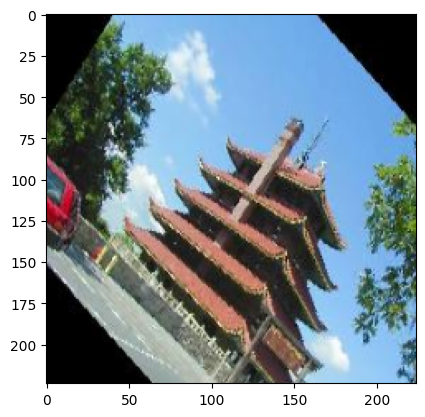

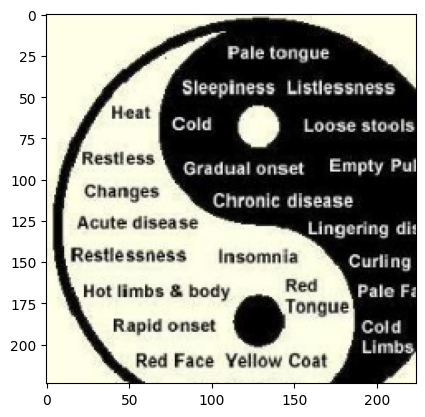

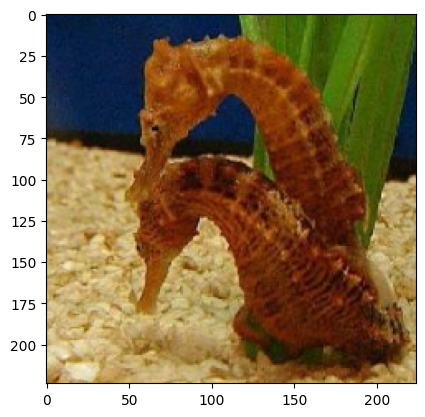

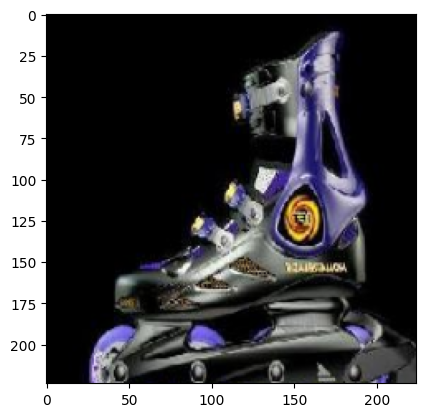

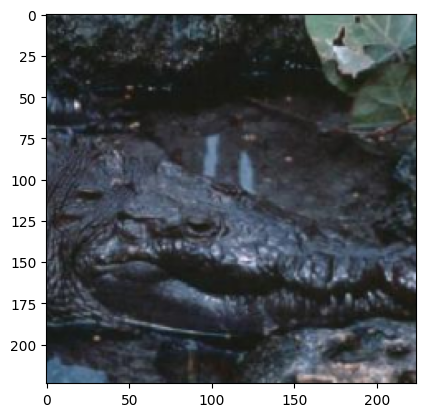

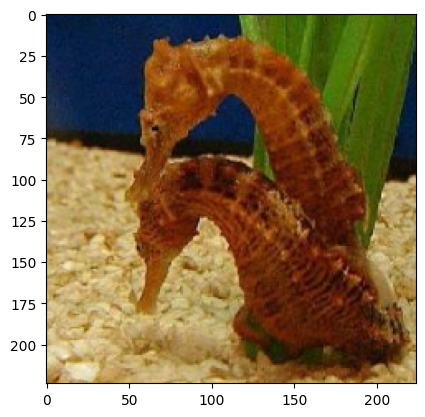

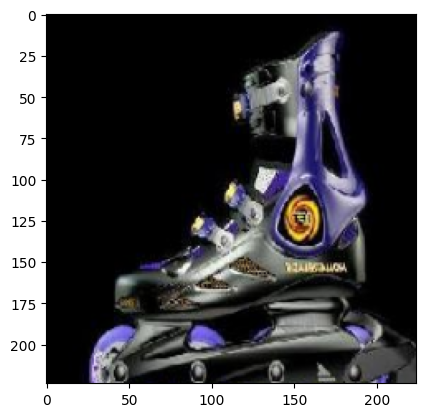

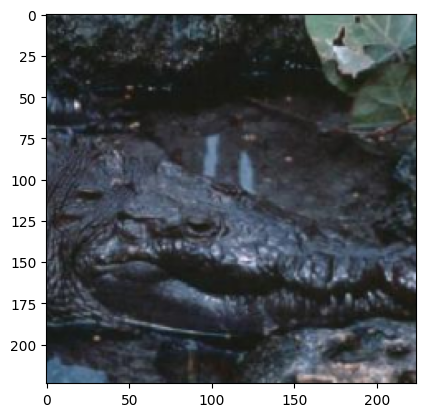

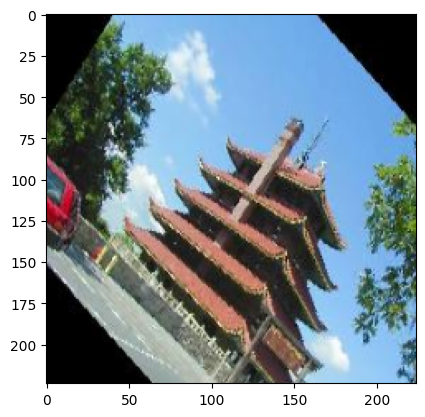

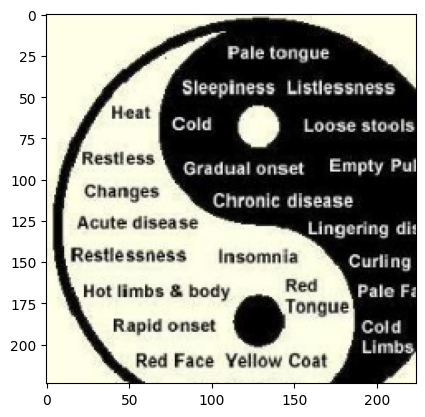

In [27]:
for element in dataloader:
    fig = plt.figure
    plt.imshow(element["image"])
    plt.show()

## Checkpointing
We provide `PyGrainCheckpointHandler` to checkpoint the iterator returned by PyGrain. It is recommended to use it with [Orbax](https://github.com/google/orbax), which can checkpoint both input pipeline and model and handles the edge cases for distributed training.

### Integration with Orbax
[Orbax](https://github.com/google/orbax) contains a powerful library for checkpointing various objects - incl. Flax models and Grain DatasetIterators. This makes it easy to checkpoint the DatasetIterator together with the model in a multihost environment. Orbax will take care of synchronizing all JAX processes.

In [19]:
data_iter = iter(dataloader)

# Read some elements.
for i in range(5):
    x = next(data_iter)
    print(i, x["image/file_name"], x["label"])

0 b'image_0030.jpg' 70
1 b'image_0039.jpg' 101
2 b'image_0049.jpg' 83
3 b'image_0009.jpg' 51
4 b'image_0045.jpg' 26


In [22]:
from orbax import checkpoint

checkpointer = checkpoint.Checkpointer(pygrain.PyGrainCheckpointHandler())

!rm -rf /tmp/orbax

# Save the checkpoint
checkpointer.save("/tmp/orbax", data_iter)

!ls /tmp/orbax

process_0-of-1.json


In [23]:
!cat /tmp/orbax/*.json

{
    "version": 2,
    "last_seen_indices": {
        "0": 4
    },
    "last_worker_index": -1,
    "worker_count": 0,
    "sampler": "IndexSampler(num_records=5, shard_options=ShardOptions(shard_index=0, shard_count=1, drop_remainder=True), shuffle=True, num_epochs=2, seed=0)",
    "data_source": "DataSource(name=caltech101, split='train', decoders=None)"
}

Note: the checkpoint contains the string representation of the sampler and the data_source. Checkpoints are only valid when loaded with the same sampler/data_source and PyGrain uses the string representation for a basic check.

In [24]:
# Read more elements and advance the iterator
for i in range(5, 10):
    x = next(data_iter)
    print(i, x["image/file_name"], x["label"])

5 b'image_0049.jpg' 83
6 b'image_0009.jpg' 51
7 b'image_0045.jpg' 26
8 b'image_0030.jpg' 70
9 b'image_0039.jpg' 101


In [30]:
# Restore iterator from previously saved checkpoint
checkpointer.restore(directory="/tmp/orbax", item=data_iter)

In [31]:
# Iterator should be set back to start from 5.
for i in range(5, 10):
    x = next(data_iter)
    print(i, x["image/file_name"], x["label"])

5 b'image_0049.jpg' 83
6 b'image_0009.jpg' 51
7 b'image_0045.jpg' 26
8 b'image_0030.jpg' 70
9 b'image_0039.jpg' 101


## Extras

### In Memory Data Source

PyGrain supports in-memory data source for sequences that is sharable among mutiple processes.

This is efficient as it avoids replicating the data memory to each worker process.

Note: Currently this constrains storable values to only the int, float, bool, str (less than
10M bytes each), bytes (less than 10M bytes each), and None built-in data types.

In [32]:
in_memory_datasource = pygrain.InMemoryDataSource(range(5))

print(in_memory_datasource)
print(f"First Record Read: {in_memory_datasource[0]}")

InMemoryDataSource(name=psm_8a0549c3, len=5)
First Record Read: 0


In [33]:
data_loader = pygrain.DataLoader(
    data_source=in_memory_datasource,
    sampler=pygrain.IndexSampler(
      num_records=len(in_memory_datasource),
      num_epochs=2,
      shard_options=pygrain.NoSharding(),
      shuffle=True,
      seed=0),
    worker_count=5)

data_iter = iter(data_loader)

for i in range(len(in_memory_datasource) * 2):
    x = next(data_iter)
    print(x)

0
4
1
2
3
1
2
3
0
4


### Convenient Method for creating DataLoader

Instead of creating a `pygrain.DataLoader` object by providing `Sampler` object, you can use `pygrain.load()`
as a single entry point by providing flatted `Sampler`.

In [34]:
dataloader = pygrain.load(
    source=tfds_datasource,
    num_epochs=2,
    shuffle=True,
    seed=0,
    shard_options=pygrain.ShardOptions(shard_index=0, shard_count=1, drop_remainder=True),
    transformations=operations,
    worker_count=0)

### Per-worker ReadOptions

You can configure per-worker data source read options (for example, number of threads, prefetch buffer size) in `ReadOptions`.

In [35]:
# Following configuration makes 8*10=80 threads reading data.
dataloader = pygrain.load(
    source=tfds_datasource,
    num_epochs=2,
    shuffle=True,
    seed=0,
    shard_options=pygrain.ShardOptions(shard_index=0, shard_count=1, drop_remainder=True),
    transformations=operations,
    worker_count=10,
    read_options=pygrain.ReadOptions(num_threads=8, prefetch_buffer_size=500))